## What platform will the game be most popular on? 
- strategy: 
    1. One hot encoding platform and genre, and use them as features to predict user_score
    2. The model takes one platform each time and calculate user_score
    3. Find the highest user_score and return the platform
- compare Sequential model and RandomForestRegressor

### Loading the data and other imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/games_of_all_time.csv')

### Exploratory Data Analysis

In [2]:
data.head()

,game_name,meta_score,user_score,platform,description,url,developer,genre,type,rating
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,['nintendo-64'],"As a young boy, Link is tricked by Ganondorf, ...",https://www.metacritic.com/game/nintendo-64/th...,Nintendo,"['Action Adventure', 'Fantasy']",singleplayer,E
1,Super Mario Galaxy,97.0,91.0,['wii'],[Metacritic's 2007 Wii Game of the Year] The u...,https://www.metacritic.com/game/wii/super-mari...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E
2,Super Mario Galaxy 2,97.0,91.0,['wii'],"Super Mario Galaxy 2, the sequel to the galaxy...",https://www.metacritic.com/game/wii/super-mari...,Nintendo EAD Tokyo,"['Action', 'Platformer', '3D']",singleplayer,E
3,Metroid Prime,97.0,89.0,['gamecube'],Samus returns in a new mission to unravel the ...,https://www.metacritic.com/game/gamecube/metro...,Retro Studios,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']",singleplayer,T
4,Super Mario Odyssey,97.0,89.0,['switch'],New Evolution of Mario Sandbox-Style Gameplay....,https://www.metacritic.com/game/switch/super-m...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E10+


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8831 entries, 0 to 8830
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_name    8831 non-null   object 
 1   meta_score   8831 non-null   float64
 2   user_score   8831 non-null   float64
 3   platform     8831 non-null   object 
 4   description  8831 non-null   object 
 5   url          8831 non-null   object 
 6   developer    8821 non-null   object 
 7   genre        8827 non-null   object 
 8   type         6727 non-null   object 
 9   rating       7691 non-null   object 
dtypes: float64(2), object(8)
memory usage: 690.0+ KB


### Data PreProcessing
- remove null data
- remove data without enough information
- transform list of string to columns(one-hot encoding)
- merge related platforms(PlayStations, Xbox, Wii)

In [4]:
data.isnull().sum()

game_name         0
meta_score        0
user_score        0
platform          0
description       0
url               0
developer        10
genre             4
type           2104
rating         1140
dtype: int64

In [5]:
df = data[['user_score', 'meta_score', 'platform', 'genre', 'type', 'rating']]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5936 entries, 0 to 8830
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_score  5936 non-null   float64
 1   meta_score  5936 non-null   float64
 2   platform    5936 non-null   object 
 3   genre       5936 non-null   object 
 4   type        5936 non-null   object 
 5   rating      5936 non-null   object 
dtypes: float64(2), object(4)
memory usage: 324.6+ KB


#### convert list to string as a new column

In [6]:
from ast import literal_eval

df['genre'] = df['genre'].apply(literal_eval)
df = df.explode('genre', 'true')

df['platform'] = df['platform'].apply(literal_eval)
df = df.explode('platform', 'true')

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28052 entries, 0 to 28051
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_score  28052 non-null  float64
 1   meta_score  28052 non-null  float64
 2   platform    28052 non-null  object 
 3   genre       28052 non-null  object 
 4   type        28052 non-null  object 
 5   rating      28052 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.3+ MB


,user_score,meta_score,platform,genre,type,rating
0,91.0,99.0,nintendo-64,Action Adventure,singleplayer,E
1,91.0,99.0,nintendo-64,Fantasy,singleplayer,E
2,91.0,97.0,wii,Action,singleplayer,E
3,91.0,97.0,wii,Platformer,singleplayer,E
4,91.0,97.0,wii,3D,singleplayer,E
5,91.0,97.0,wii,Action,singleplayer,E
6,91.0,97.0,wii,Platformer,singleplayer,E
7,91.0,97.0,wii,3D,singleplayer,E
8,89.0,97.0,gamecube,Action,singleplayer,T
9,89.0,97.0,gamecube,Shooter,singleplayer,T


#### merge similar platforms

In [7]:
# should we replace multiple similar platform values to a single value e.g ps1,ps2 as ps
df['platform'] = df['platform'].replace([
    'playstation-4', 'playstation-3', 'playstation-2', 'playstation-vita',
    'playstation-5'
], 'playstation')
df['platform'] = df['platform'].replace(
    ['xbox-360', 'xbox-one', 'xbox-series-x'], 'xbox')
df['platform'] = df['platform'].replace(['wii-u'], 'wii')

In [8]:
df['platform'].value_counts()

playstation         8355
pc                  6147
xbox                5831
switch              2056
wii                 1323
ds                  1269
psp                 1033
gamecube             869
game-boy-advance     672
3ds                  359
nintendo-64           97
dreamcast             36
stadia                 5
Name: platform, dtype: int64

In [9]:
# remove the genre values which have less data
df = df[df.groupby('genre').genre.transform('count') > 100].copy()

In [10]:
df['genre'].value_counts()

Action               2864
General              1885
Action Adventure     1333
Shooter              1096
Role-Playing         1019
Sports                907
Arcade                902
Miscellaneous         808
First-Person          753
3D                    690
Strategy              658
Platformer            638
2D                    618
Racing                574
Traditional           567
Sci-Fi                555
Adventure             550
Modern                542
Fantasy               528
Driving               492
Sim                   468
Third-Person          464
Simulation            445
Action RPG            426
Automobile            335
Fighting              319
Team                  289
Beat-'Em-Up           278
Open-World            270
Real-Time             262
Puzzle                256
Historic              252
Turn-Based            246
Compilation           222
Individual            221
Japanese-Style        199
Survival              181
Tactical              177
Console-styl

#### check if type is balanced

<AxesSubplot:xlabel='type', ylabel='count'>

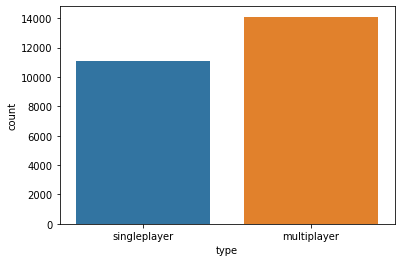

In [11]:
sns.countplot(x='type', data=df)

#### check rating distribution

<AxesSubplot:xlabel='rating', ylabel='count'>

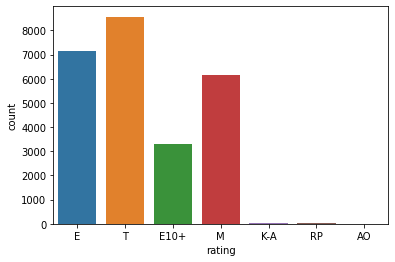

In [12]:
sns.countplot(x='rating', data=df)

#### remove rating in K-A, RP, AO

In [13]:
df = df.drop(df[df['rating'].isin(['K-A', 'RP', 'AO'])].index)

#### One-hot encoding

In [14]:
# hot encoding
df = pd.get_dummies(df,
                    columns=['platform', 'genre', 'type', 'rating'],
                    prefix=['platform', 'genre', 'type', 'rating'])

### Train Test Split (label = user_score)

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(['user_score', 'meta_score'], axis=1).values
y = df['user_score'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

### Normalizing the Data
- what features do we need to normalize?
- the only numeric columns are user_score and meta_score, so we can't scale our data.

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

### Creating the Model

In [19]:
df.info

<bound method DataFrame.info of        user_score  meta_score  platform_3ds  platform_dreamcast  platform_ds  \
0            91.0        99.0             0                   0            0   
1            91.0        99.0             0                   0            0   
2            91.0        97.0             0                   0            0   
3            91.0        97.0             0                   0            0   
4            91.0        97.0             0                   0            0   
...           ...         ...           ...                 ...          ...   
28047        73.0        70.0             0                   0            0   
28048        73.0        70.0             0                   0            0   
28049        50.0        50.0             0                   0            0   
28050        50.0        50.0             0                   0            0   
28051        50.0        50.0             0                   0            0   

       

#### Sequential Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# Create EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=25)

seq_model = Sequential()

seq_model.add(Dense(72, activation='relu'))
seq_model.add(Dropout(0.2))

seq_model.add(Dense(36, activation='relu'))
seq_model.add(Dropout(0.2))

seq_model.add(Dense(1))

seq_model.compile(optimizer='adam', loss='mse')

2022-05-10 00:18:00.792839: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
seq_model.fit(X_train,
              y_train,
              validation_data=(X_test, y_test),
              batch_size=128,
              epochs=1000,
              callbacks=[early_stop])

Epoch 1/1000
158/158 [==============================] - 1s 2ms/step - loss: 2546.1204 - val_loss: 178.1147
Epoch 2/1000
158/158 [==============================] - 0s 1ms/step - loss: 245.4567 - val_loss: 166.2490
Epoch 3/1000
158/158 [==============================] - 0s 1ms/step - loss: 240.0093 - val_loss: 163.2530
Epoch 4/1000
158/158 [==============================] - 0s 1ms/step - loss: 234.2286 - val_loss: 163.3624
Epoch 5/1000
158/158 [==============================] - 0s 1ms/step - loss: 233.2439 - val_loss: 163.4902
Epoch 6/1000
158/158 [==============================] - 0s 1ms/step - loss: 233.6817 - val_loss: 162.5445
Epoch 7/1000
158/158 [==============================] - 0s 1ms/step - loss: 232.6054 - val_loss: 162.1942
Epoch 8/1000
158/158 [==============================] - 0s 1ms/step - loss: 229.9800 - val_loss: 162.2049
Epoch 9/1000
158/158 [==============================] - 0s 1ms/step - loss: 231.1905 - val_loss: 163.1921
Epoch 10/1000
158/158 [======================

Text(0, 0.5, 'Loss')

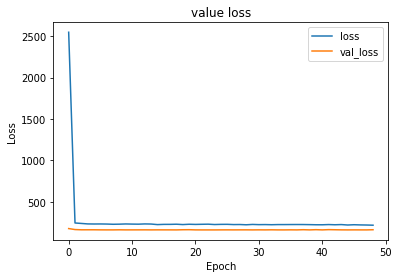

In [23]:
losses = pd.DataFrame(seq_model.history.history)
losses[['loss', 'val_loss']].plot()
plt.title("value loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#### Evaluating Model Performance

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

seq_pred = seq_model.predict(X_test)
print(f'MAE: %d' % mean_absolute_error(y_test, seq_pred))
print(f'MSE: %d' % np.sqrt(mean_squared_error(y_test, seq_pred)))
print(f'score: %d' % explained_variance_score(y_test, seq_pred))

MAE: 10
MSE: 12
score: 0


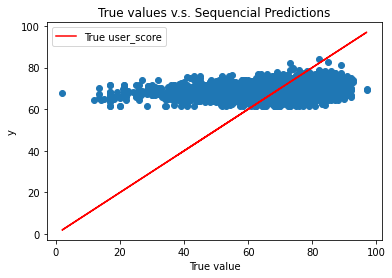

In [25]:
plt.scatter(y_test, seq_pred)
plt.plot(y_test, y_test, 'r', label='True user_score')
plt.title("True values v.s. Sequencial Predictions")
plt.xlabel("True value")
plt.ylabel("y")
plt.legend()
plt.show()

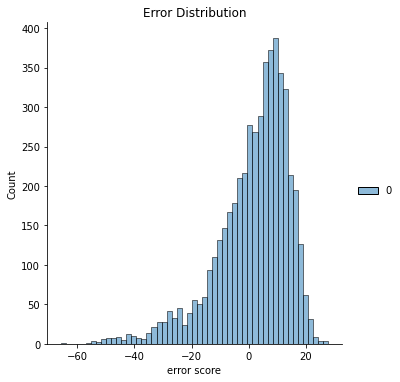

In [26]:
p_shape = seq_pred.shape
errors = y_test.reshape(p_shape[0], p_shape[1]) - seq_pred
sns.displot(errors)
plt.title("Error Distribution")
plt.xlabel("error score")
plt.show()

#### RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
rfr_model = RandomForestRegressor(n_estimators=100, random_state=0)
rfr_model.fit(X_train, y_train)
rfr_pred = rfr_model.predict(X_test)

#### Evaluating Model Performance

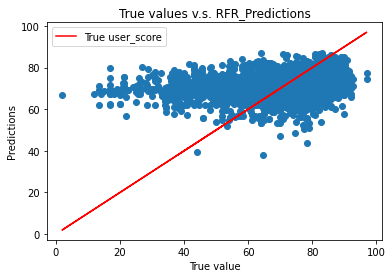

In [29]:
plt.scatter(y_test, rfr_pred)
plt.plot(y_test, y_test, 'r', label='True user_score')
plt.title("True values v.s. RFR_Predictions")
plt.xlabel("True value")
plt.ylabel("Predictions")
plt.legend()
plt.show()

In [30]:
from sklearn import metrics

print('R2 score: ', rfr_model.score(X_test, y_test))
mse = metrics.mean_squared_error(y_test, rfr_pred)
print('MSE:', mse)

R2 score:  -0.009060072910424433
MSE: 171.1769492599751


In [31]:
platform_col = [col for col in df if col.startswith('platform')]
platform_col

['platform_3ds',
 'platform_dreamcast',
 'platform_ds',
 'platform_game-boy-advance',
 'platform_gamecube',
 'platform_nintendo-64',
 'platform_pc',
 'platform_playstation',
 'platform_psp',
 'platform_stadia',
 'platform_switch',
 'platform_wii',
 'platform_xbox']

In [32]:
genre_col = [col for col in df if col.startswith('genre')]
genre_col

['genre_2D',
 'genre_3D',
 'genre_Action',
 'genre_Action Adventure',
 'genre_Action RPG',
 'genre_Adventure',
 'genre_Alternative',
 'genre_Arcade',
 'genre_Automobile',
 'genre_Basketball',
 "genre_Beat-'Em-Up",
 'genre_Combat',
 'genre_Compilation',
 'genre_Console-style RPG',
 'genre_Driving',
 'genre_Fantasy',
 'genre_Fighting',
 'genre_First-Person',
 'genre_Football',
 'genre_GT / Street',
 'genre_General',
 'genre_Historic',
 'genre_Horror',
 'genre_Individual',
 'genre_Japanese-Style',
 'genre_Linear',
 'genre_Management',
 'genre_Miscellaneous',
 'genre_Modern',
 'genre_Music',
 'genre_Open-World',
 'genre_Platformer',
 'genre_Puzzle',
 'genre_Racing',
 'genre_Real-Time',
 'genre_Rhythm',
 'genre_Role-Playing',
 'genre_Sci-Fi',
 "genre_Shoot-'Em-Up",
 'genre_Shooter',
 'genre_Sim',
 'genre_Simulation',
 'genre_Soccer',
 'genre_Sports',
 'genre_Strategy',
 'genre_Survival',
 'genre_Tactical',
 'genre_Tactics',
 'genre_Team',
 'genre_Third-Person',
 'genre_Traditional',
 'genre

### Create the function for best platform prediction

In [33]:
def get_best_platform(col_index, genre, type, rating, model):
    most_popular_platform = ''
    user_score = 0

    col_len = len(col_index)
    test = np.zeros(len(col_index))
    test[col_index.get_loc(type)] = 1
    test[col_index.get_loc(rating)] = 1

    for g in genre:
        test[col_index.get_loc(g)] = 1

    for p in platform_col:
        test[col_index.get_loc(p)] = 1

        predict_score = model.predict(test.reshape(1, col_len))
        print(f'%s: %d' % (p, predict_score))
        if (user_score < predict_score):
            user_score = predict_score
            most_popular_platform = p

        test[col_index.get_loc(p)] = 0

    return most_popular_platform

In [34]:
df_copy = df.drop(columns=['user_score', 'meta_score'])
predict_platform = get_best_platform(
    df_copy.columns, ['genre_3D', 'genre_Shooter', 'genre_Horror'],
    'type_singleplayer', 'rating_E', seq_model)
print(f'sequential model predict: %s\n' % predict_platform)

predict_platform = get_best_platform(
    df_copy.columns, ['genre_3D', 'genre_Shooter', 'genre_Horror'],
    'type_singleplayer', 'rating_E', rfr_model)
print(f'RandomForestRegressor model predict: %s\n' % predict_platform)

platform_3ds: 88
platform_dreamcast: 92
platform_ds: 86
platform_game-boy-advance: 89
platform_gamecube: 90
platform_nintendo-64: 96
platform_pc: 86
platform_playstation: 86
platform_psp: 89
platform_stadia: 92
platform_switch: 87
platform_wii: 87
platform_xbox: 86
sequential model predict: platform_nintendo-64

platform_3ds: 66
platform_dreamcast: 68
platform_ds: 66
platform_game-boy-advance: 65
platform_gamecube: 62
platform_nintendo-64: 86
platform_pc: 71
platform_playstation: 68
platform_psp: 67
platform_stadia: 66
platform_switch: 67
platform_wii: 67
platform_xbox: 71
RandomForestRegressor model predict: platform_nintendo-64



In [35]:
import pickle

filename = 'q4_seq_model.sav'
pickle.dump(seq_model, open(filename, 'wb'))

filename = 'q4_rfr_model.sav'
pickle.dump(rfr_model, open(filename, 'wb'))

2022-05-10 00:18:17.378551: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://dbb9dfba-fc71-427c-ac5e-2543f68598e1/assets
